# EP1 - Conjunto de Maldelbrot e paralelização com pThreads e OpenMP

| Nome | NUSP |
|------|------|
| Giulia C. de Nardi | 10692203 |
| Vitor D. Tamae | 10705620 |
| Lucy Anne de Omena Evangelista | 11221776 |
| Leonardo Costa Santos | 10783142 |
| Alexandre Muller Jones | 8038149 |


INFORMAÇÔES SOBRE O DESENVOLVIMENTO DO RELATÓRIO:

- **Para o caso dos mandelbrot paralelizados, podemos ter dois tempos como saída: o considerando o tempo de alocação de memória e I/O, e o tempo não considerando esses fatores. Ainda não implementado para a realização das funções, mas de fácil ajuste nas funções feitas neste notebook.**


## Configuração do ambiente

Atualizando os pacotes Julia

In [9]:
] up

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]


Verificando o status dos pacotes, e se há algum problema, com o comando:

In [10]:
] st

    Status `~/.julia/environments/v1.3/Project.toml`
  [a93c6f00] DataFrames v0.21.0
  [7073ff75] IJulia v1.21.2


## Funções para realização dos experimentos

In [11]:
; make mandelbrot_seq

make: 'mandelbrot_seq' is up to date.


In [12]:
; ./mandelbrot_seq

usage: ./mandelbrot_seq c_x_min c_x_max c_y_min c_y_max image_size
examples with image_size = 11500:
    Full Picture:         ./mandelbrot_seq -2.5 1.5 -2.0 2.0 11500
    Seahorse Valley:      ./mandelbrot_seq -0.8 -0.7 0.05 0.15 11500
    Elephant Valley:      ./mandelbrot_seq 0.175 0.375 -0.1 0.1 11500
    Triple Spiral Valley: ./mandelbrot_seq -0.188 -0.012 0.554 0.754 11500


In [13]:
; ./mandelbrot_seq 0.175 0.375 -0.1 0.1 200 0

0.039157


A função abaixo recebe parâmetros `size`, com o tamanho da imagem, `f`, com a id do tupo de fractal a ser feito (0 - Full, 2 - Triple Spiral, 3 - Elephant, 4 - Seahorse), `mandel`, com o nome da função a ser executada (`./mandelbrot_seq`, `./mandelbrot_opm`, `./mandelbrot_pth`),e `threads`, com o número de threads do programa paralelo. A função executa o programa `mandelbrot` com os parâmetros dados e devolve um `DataFrame` com os resultados.

In [20]:
using DataFrames, Query, StatsPlots, Statistics

function measure_mandelbrot(size, f, mandel; thread = 0)    
    if f == 0  mode = `-2.5 1.5 -2.0 2.0` #full
    elseif f == 1  mode = `-0.188 -0.012 0.554 0.754` #triple spiral
    elseif f == 2  mode = `0.175 0.375 -0.1 0.1` # elephant
    elseif f == 3  mode = `-0.8 -0.7 0.05 0.15` #seahorse
    end
    
    if thread != 0 
    results = parse.(Float64,
        read(`./$mandel $mode $size $thread`, String))
    else
    results = parse.(Float64,
        read(`./$mandel $mode $size`, String))
    end
        
    return DataFrame(size = size,
        f = f,
        threads = thread,
        duration = results[1])
end

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1273


measure_mandelbrot (generic function with 1 method)

A função `run_experiments` recebe os mesmos parâmetros `size`, `f`,`mandel` e `threads`, e um parâmetro adicional `repetitions`, com o número de repetições de cada experimento com um dado número de `threads`. A função devolve um `DataFrame` com todos os experimentos.

In [21]:
function run_experiments(size, f, mandel, repetitions; threads = [])
    run(`make $mandel`)
    
    results = DataFrame(size = Int[],
        f = Int[],
        threads = Int[],
        duration = Float64[]) 
    
    if threads != []
    for t in threads
        for s in size
        for r in 1:repetitions
            append!(results,
                measure_mandelbrot(s, f, mandel, thread = t))    
        end
        end
    end
    else
        for r in 1:repetitions
        for s in size
            append!(results,
                measure_mandelbrot(s, f, mandel))    
        end
        end
    end 
    
    return results
end

run_experiments (generic function with 1 method)

A função `parse_results` recebe um `DataFrame` de resultados, produzido pela função `run_experiments`. A função devolve um `DataFrame` com a média e o intervalo de confiança da média a 95% dos tempos de execução, agrupados por número de threads.

In [22]:
function parse_results(results)
    parsed_results = results |>
                    @groupby({_.threads,_.size}) |>
                    @map({threads = key(_).threads,
                          size = _.size[1],
                          mean_duration = mean(_.duration),
                          ci_duration = 1.96 * std(_.duration)}) |>
                    DataFrame
    
    return parsed_results
end

parse_results (generic function with 1 method)

## Funções para traçar gráficos

A função abaixo permite que sejam traçadas até 5 séries de dados em um mesmo gráfico do tipo scatter.

In [25]:
pgfplotsx()

function plot_results(x, y, series_label, yerror; y2 = [], series_label2 = [], yerror2 = [], 
        y3 = [], series_label3 = [], yerror3 = [], y4 = [], series_label4 = [], yerror4 = [],
        y5 = [], series_label5 = [], yerror5 = [])
    max_thread_power = 5
    
    p = scatter(x, y, xaxis = :log2, xlabel = "Threads", xticks = [2 ^ x for x in 0:max_thread_power],
        yerror = yerror, alpha = 0.6, 
        labels = series_label, legend = :bottomright)
    
    if y2 != []
        p = scatter!(x, y2, xaxis = :log2, xticks = [2 ^ x for x in 0:max_thread_power],
            yerror = yerror2, alpha = 0.6,
            labels = series_label2, legend = :bottomright)
    end
    if y3 != []
        p = scatter!(x, y3, xaxis = :log2, xticks = [2 ^ x for x in 0:max_thread_power],
            yerror = yerror3, alpha = 0.6,
            labels = series_label3, legend = :bottomright)
    end
    if y4 != []
        p = scatter!(x, y4, xaxis = :log2, xticks = [2 ^ x for x in 0:max_thread_power],
            yerror = yerror4, alpha = 0.6,
            labels = series_label4, legend = :bottomright)
    end
    if y5 != []
        p = scatter!(x, y5, xaxis = :log2, xticks = [2 ^ x for x in 0:max_thread_power],
            yerror = yerror5, alpha = 0.6,
            labels = series_label5, legend = :bottomright)
    end
    
    return p
end

┌ Info: Precompiling PGFPlotsX [8314cec4-20b6-5062-9cdb-752b83310925]
└ @ Base loading.jl:1273
┌ Info: Precompiling Contour [d38c429a-6771-53c6-b99e-75d170b6e991]
└ @ Base loading.jl:1273


plot_results (generic function with 1 method)

## Condições para os experimentos

In [24]:
size = [2 ^ x for x in 4:13]
thread = [2 ^ x for x in 0:5]
repetitions = 10;

## Mandelbrot sequencial

Nesta parte, traremos a execução do maldelbrot em sua versão sequencial, junto com a análise de tempo de execução para os diferentes tipo de fractais (Triple Spiral, Elephant, Seahorse & Full) e em diferentes resoluções ($ 2^4 \cdots 2^{13}$)

Realizando as medições para o mandelbrot sequencial:

In [11]:
results = run_experiments(size, 0, "mandelbrot_seq", repetitions)
seq_full = parse_results(results)

make: 'mandelbrot_seq' is up to date.


,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,0,16,8.81e-5,3.21457e-5
2,0,32,0.0003463,0.000308654
3,0,64,0.0011882,0.000462979
4,0,128,0.0045518,0.00183678
5,0,256,0.0179811,0.00800325
6,0,512,0.0663697,0.0391323
7,0,1024,0.265033,0.16082
8,0,2048,0.776764,0.411441
9,0,4096,3.04184,1.38216


In [33]:
results = run_experiments(size, 1, "mandelbrot_seq", repetitions)
seq_triplespiral = parse_results(results);

make: 'mandelbrot_seq' is up to date.


In [34]:
results = run_experiments(size, 2, "mandelbrot_seq", repetitions)
seq_elephant = parse_results(results);

make: 'mandelbrot_seq' is up to date.


In [35]:
results = run_experiments(size, 3, "mandelbrot_seq", repetitions)
seq_seahorse = parse_results(results);

make: 'mandelbrot_seq' is up to date.


In [50]:
showall(seq_seahorse)

10×4 DataFrame
│ Row │ threads │ size  │ mean_duration │ ci_duration │
│     │ Int64   │ Int64 │ Float64       │ Float64     │
├─────┼─────────┼───────┼───────────────┼─────────────┤
│ 1   │ 0       │ 16    │ 0.0003967     │ 0.000197817 │
│ 2   │ 0       │ 32    │ 0.0014979     │ 0.00091014  │
│ 3   │ 0       │ 64    │ 0.0059669     │ 0.00361696  │
│ 4   │ 0       │ 128   │ 0.022989      │ 0.0154198   │
│ 5   │ 0       │ 256   │ 0.0830625     │ 0.0610161   │
│ 6   │ 0       │ 512   │ 0.284023      │ 0.183647    │
│ 7   │ 0       │ 1024  │ 1.04632       │ 0.299888    │
│ 8   │ 0       │ 2048  │ 5.07424       │ 0.966617    │
│ 9   │ 0       │ 4096  │ 19.8162       │ 4.17241     │
│ 10  │ 0       │ 8192  │ 78.8697       │ 13.7573     │

## Mandelbrot com pthreads

In [31]:
results = run_experiments(size, 0, "mandelbrot_pth", repetitions,threads=thread)
pth_full = parse_results(results)

make: 'mandelbrot_pth' is up to date.


,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,1,16,0.0001323,3.90587e-5
2,1,32,0.0002998,8.53234e-5
3,1,64,0.0008287,3.88945e-5
4,1,128,0.0028507,0.000102571
5,1,256,0.0098278,0.00131417
6,1,512,0.038357,0.00219532
7,1,1024,0.144756,0.00586807
8,1,2048,0.796659,0.531016
9,1,4096,3.51485,1.18519


In [51]:
results = run_experiments(size, 1, "mandelbrot_pth", repetitions,threads=thread)
pth_triplespiral = parse_results(results);

gcc -pthread -o mandelbrot_pth mandelbrot_pth.c


InterruptException: InterruptException:

In [52]:
results = run_experiments(size, 2, "mandelbrot_pth", repetitions,threads=thread)
pth_elephant = parse_results(results);

make: 'mandelbrot_pth' is up to date.


InterruptException: InterruptException:

In [53]:
results = run_experiments(size, 3, "mandelbrot_pth", repetitions,threads=thread)
pth_seahorse = parse_results(results);

make: 'mandelbrot_pth' is up to date.


InterruptException: InterruptException:

## Mandelbrot com OpenMP

In [30]:
results = run_experiments(size, 0, "mandelbrot_omp", repetitions,threads=thread)
omp_full = parse_results(results)

make: 'mandelbrot_omp' is up to date.


,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,1,16,8.34e-5,1.51032e-5
2,1,32,0.0002593,5.25034e-5
3,1,64,0.0007741,8.20991e-5
4,1,128,0.0027196,0.000378152
5,1,256,0.0098522,0.00121178
6,1,512,0.0364775,0.00131803
7,1,1024,0.208259,0.161465
8,1,2048,0.839414,0.696352
9,1,4096,3.54475,1.25549


In [46]:
results = run_experiments(size, 1, "mandelbrot_omp", repetitions,threads=thread)
omp_triplespiral = parse_results(results);

make: 'mandelbrot_omp' is up to date.


In [47]:
results = run_experiments(size, 2, "mandelbrot_omp", repetitions,threads=thread)
omp_elephant = parse_results(results);

make: 'mandelbrot_omp' is up to date.


In [48]:
results = run_experiments(size, 3, "mandelbrot_omp", repetitions,threads=thread)
omp_seahorse = parse_results(results);

make: 'mandelbrot_omp' is up to date.


In [49]:
showall(omp_seahorse)

60×4 DataFrame
│ Row │ threads │ size  │ mean_duration │ ci_duration │
│     │ Int64   │ Int64 │ Float64       │ Float64     │
├─────┼─────────┼───────┼───────────────┼─────────────┤
│ 1   │ 1       │ 16    │ 0.0005749     │ 6.05274e-5  │
│ 2   │ 1       │ 32    │ 0.0021911     │ 7.65903e-5  │
│ 3   │ 1       │ 64    │ 0.0087471     │ 0.000259819 │
│ 4   │ 1       │ 128   │ 0.0347141     │ 0.000435634 │
│ 5   │ 1       │ 256   │ 0.139952      │ 0.00311937  │
│ 6   │ 1       │ 512   │ 0.558083      │ 0.0121486   │
│ 7   │ 1       │ 1024  │ 1.65257       │ 0.971551    │
│ 8   │ 1       │ 2048  │ 7.14823       │ 2.36527     │
│ 9   │ 1       │ 4096  │ 28.0738       │ 8.6815      │
│ 10  │ 1       │ 8192  │ 144.212       │ 16.0117     │
│ 11  │ 2       │ 16    │ 0.0004016     │ 1.21948e-5  │
│ 12  │ 2       │ 32    │ 0.0013323     │ 0.000136342 │
│ 13  │ 2       │ 64    │ 0.0049774     │ 4.93013e-5  │
│ 14  │ 2       │ 128   │ 0.0196335     │ 0.000193219 │
│ 15  │ 2       │ 256   │ 0.06374

## Gráficos comparativos

Ao final, teremos os dataframes:

|Dataframe | Full | Triple Spiral | Seahorse |
|----------|--------|--------|--------|
|Sequencial|seq_full|seq_triplespiral|seq_seahorse|
|PThreads|pth_full|pth_triplespiral|pth_seahorse|
|OpenMP|omp_full|omp_triplespiral|omp_seahorse|

Realizaremos os gráficos a partir de partições do dataframe, como mostrados abaixo:

In [26]:
filter(row -> row[:threads] == 1, parsed_results)

UndefVarError: UndefVarError: parsed_results not defined

In [43]:
filter(row -> row[:size] == 16, parsed_results)

UndefVarError: UndefVarError: parsed_results not defined

In [44]:
filter(row -> row[:size] == 16, parsed_results).mean_duration

UndefVarError: UndefVarError: parsed_results not defined

### Comparando desempenho por tamanho da imagem

Ideias para os gráficos: 
> Comparar desempenho por tamanho da imagem ( 5 grafos > para tamanhos das imagens. Cada serie no grafico deve ser uma forma gerar a imagem)

> Comparar desempenho por tipo de gráfico produzido ( 3 x 4 gráficos, 4 áreas com 3 tipos de calculo cada / cruzar com tamanho da entrada também? daí seriam 4x 3 x 10)

> estou confouzer, me ajudem a saber quais gráficos fazer

In [45]:
plot_results(
    filter(row -> row[:size] == 16, parsed_results).threads,
    filter(row -> row[:size] == 16, parsed_results).mean_duration,    
    "16", filter(row -> row[:size] == 16, parsed_results).ci_duration,
    y2 = filter(row -> row[:size] == 32, parsed_results).mean_duration,
    series_label2 = "32", yerror2 = filter(row -> row[:size] == 32, parsed_results).ci_duration)

UndefVarError: UndefVarError: parsed_results not defined

### Comparando desempenho por quantidade de threads

In [36]:
using CSV

function save_csv_results(results,filename)
    println(filename)
    CSV.write(filename, results)
end
using CSV

function read_csv_results(filename)
    results=CSV.read(filename)
    return results
end


┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1273


read_csv_results (generic function with 1 method)

In [37]:
save_csv_results(seq_full,"data/seq_full.csv")
save_csv_results(seq_triplespiral,"data/seq_triplespiral.csv")
save_csv_results(seq_elephant,"data/seq_elephant.csv")
save_csv_results(seq_seahorse,"data/seq_seahorse.csv")

UndefVarError: UndefVarError: seq_full not defined

In [38]:
save_csv_results(omp_full,"data/omp_full.csv")
save_csv_results(omp_triplespiral,"data/omp_triplespiral.csv")
save_csv_results(omp_elephant,"data/omp_elephant.csv")
save_csv_results(omp_seahorse,"data/omp_seahorse.csv")

UndefVarError: UndefVarError: omp_full not defined

In [39]:
save_csv_results(pth_full,"data/pth_full.csv")
#save_csv_results(pth_triplespiral,"data/pth_triplespiral.csv")
#save_csv_results(pth_elephant,"data/pth_elephant.csv")
#save_csv_results(pth_seahorse,"data/pth_seahorse.csv")

UndefVarError: UndefVarError: pth_full not defined

In [45]:
function fazgrafico(filename, label)
    plot_results(filename.threads, filename.mean_duration, label, filename.ci_duration)
end   

fazgrafico (generic function with 2 methods)

In [54]:
seq_full=read_csv_results("data/seq_full.csv")
seq_triplespiral=read_csv_results("data/seq_triplespiral.csv")
seq_elephant=read_csv_results("data/seq_elephant.csv")
seq_seahorse=read_csv_results("data/seq_seahorse.csv")
omp_full=read_csv_results("data/omp_full.csv")
omp_triplespiral=read_csv_results("data/omp_triplespiral.csv")
omp_elephant=read_csv_results("data/omp_elephant.csv")
omp_seahorse=read_csv_results("data/omp_seahorse.csv")
pth_full=read_csv_results("data/pth_full.csv")

,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,1,16,0.0001323,3.90587e-5
2,1,32,0.0002998,8.53234e-5
3,1,64,0.0008287,3.88945e-5
4,1,128,0.0028507,0.000102571
5,1,256,0.0098278,0.00131417
6,1,512,0.038357,0.00219532
7,1,1024,0.144756,0.00586807
8,1,2048,0.796659,0.531016
9,1,4096,3.51485,1.18519


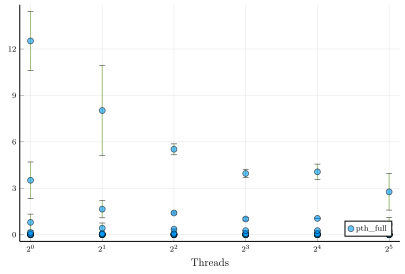

In [55]:
fazgrafico(pth_full, "pth_full")

In [57]:
fazgrafico(seq_full, "seq_full")
fazgrafico(seq_seahorse, "seq_seahorse")
fazgrafico(seq_elephant, "seq_elephant")

showall(seq_full)

┌ Warning: `showall(df::AbstractDataFrame, allcols::Bool=true)` is deprecated, use `show(df, allrows=true, allcols=allcols)` instead.
│   caller = showall(::DataFrame) at deprecated.jl:66
└ @ DataFrames ./deprecated.jl:66


10×4 DataFrame
│ Row │ threads │ size  │ mean_duration │ ci_duration │
│     │ Int64   │ Int64 │ Float64       │ Float64     │
├─────┼─────────┼───────┼───────────────┼─────────────┤
│ 1   │ 0       │ 16    │ 8.81e-5       │ 3.21457e-5  │
│ 2   │ 0       │ 32    │ 0.0003463     │ 0.000308654 │
│ 3   │ 0       │ 64    │ 0.0011882     │ 0.000462979 │
│ 4   │ 0       │ 128   │ 0.0045518     │ 0.00183678  │
│ 5   │ 0       │ 256   │ 0.0179811     │ 0.00800325  │
│ 6   │ 0       │ 512   │ 0.0663697     │ 0.0391323   │
│ 7   │ 0       │ 1024  │ 0.265033      │ 0.16082     │
│ 8   │ 0       │ 2048  │ 0.776764      │ 0.411441    │
│ 9   │ 0       │ 4096  │ 3.04184       │ 1.38216     │
│ 10  │ 0       │ 8192  │ 12.5016       │ 2.24545     │

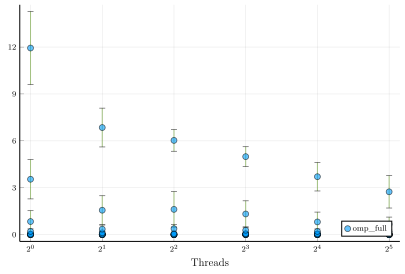

In [59]:
fazgrafico(omp_full, "omp_full")


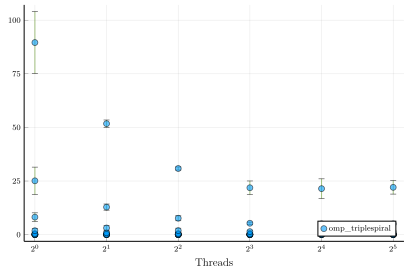

In [60]:
fazgrafico(omp_triplespiral, "omp_triplespiral")


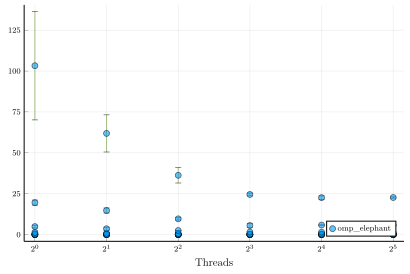

In [61]:
fazgrafico(omp_elephant, "omp_elephant")


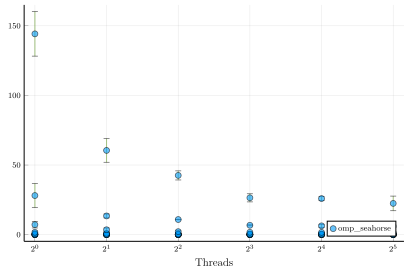

In [62]:
fazgrafico(omp_seahorse, "omp_seahorse")